In [1]:
def enumerate_smiles(smiles):#列举同一分子smiles的等价表达,得到规范化的smiles
    mol = Chem.MolFromSmiles(smiles)
    smi = Chem.MolToSmiles(mol,doRandom=False,canonical=False)
    return smi
from rdkit import Chem

# 创建分子对象（示例：乙醇）
T = '[H]'
print(enumerate_smiles(T))
mol = Chem.MolFromSmiles(T)

# 显式添加氢（可选，使氢原子可见）
mol = Chem.AddHs(mol)

# 遍历每个原子并打印信息
for atom in mol.GetAtoms():
    atom_idx = atom.GetIdx()          # 原子索引
    element = atom.GetSymbol()        # 元素种类
    bond_count = atom.GetDegree()     # 成键数目（显式连接的原子数）
    total_degree = atom.GetTotalDegree()  # 总连接数（包括隐式氢）
    
    print(f"原子索引 {atom_idx}: "
          f"元素 = {element}, "
          f"成键数目 = {bond_count}, "
          f"总连接数 = {total_degree}")

[H]
原子索引 0: 元素 = H, 成键数目 = 0, 总连接数 = 0


[14:51:19] WARNING: not removing hydrogen atom without neighbors
[14:51:19] WARNING: not removing hydrogen atom without neighbors


In [2]:
from openbabel import openbabel as ob

def print_atom_indices(smiles_or_filename):
    # 创建 Open Babel 对象
    conv = ob.OBConversion()
    mol = ob.OBMol()
    
    # 判断输入是 SMILES 还是文件名
    if "." in smiles_or_filename or "/" in smiles_or_filename or "\\" in smiles_or_filename:
        # 从文件读取分子
        if not conv.ReadFile(mol, smiles_or_filename):
            print(f"无法读取文件: {smiles_or_filename}")
            return
    else:
        # 从 SMILES 字符串读取分子
        conv.SetInFormat("smi")
        if not conv.ReadString(mol, smiles_or_filename):
            print(f"无效的 SMILES 字符串: {smiles_or_filename}")
            return
    
    # 添加氢原子（可选，显示所有氢）
    mol.AddHydrogens()
    
    # 获取原子总数
    num_atoms = mol.NumAtoms()
    print(f"分子包含 {num_atoms} 个原子:")
    
    # 遍历所有原子并打印信息
    for i in range(1, num_atoms + 1):  # Open Babel 原子索引从 1 开始
        atom = mol.GetAtom(i)
        atomic_num = atom.GetAtomicNum()
        element = ob.GetSymbol(atomic_num)
        print(f"原子序号: {i}, 元素: {element}")

# 示例用法：
# 1. 从 SMILES 字符串创建
print("从 SMILES 创建:")
print_atom_indices(T)  # 乙醇

从 SMILES 创建:
分子包含 1 个原子:
原子序号: 1, 元素: H


In [3]:
import importlib

SAFE_MODULES = {'math', 'numpy', 'os.path', 'datetime', 'json'}  # 允许的安全模块白名单

def safe_import_function(func_path):
    """
    安全导入函数（使用模块白名单）
    格式: "包名.模块名.函数名" 或 "模块名.函数名"
    """
    parts = func_path.split('.')
    if len(parts) < 2:
        raise ValueError("无效的函数路径格式")
    
    # 检查模块是否在白名单中
    module_name = '.'.join(parts[:-1])
    if module_name not in SAFE_MODULES:
        raise ImportError(f"模块 {module_name} 不在安全白名单中")
    
    module = importlib.import_module(module_name)
    return getattr(module, parts[-1])

# 使用示例
if __name__ == "__main__":
    func_str = input("请输入函数路径: ")  # 例如 "math.sqrt"
    try:
        func = safe_import_function(func_str)
        print(f"成功导入函数: {func.__name__}")
        # 测试调用（添加基本类型检查）
        if func.__name__ in ['sqrt', 'sin', 'cos']:
            print(f"{func.__name__}(4) = {func(4)}")
    except (ImportError, AttributeError, ValueError) as e:
        print(f"错误: {str(e)}")

错误: 无效的函数路径格式


In [4]:
from ase.io import read
import numpy as np

def get_fmax_from_traj(traj_file):
    """
    从轨迹文件中提取所有步骤的 fmax 值
    
    参数:
        traj_file: 轨迹文件路径
        
    返回:
        steps: 步骤编号列表
        fmax_values: 每个步骤对应的 fmax 值列表
    """
    # 读取轨迹文件中的所有结构
    structures = read(traj_file, index=':')
    
    steps = []
    fmax_values = []
    
    for i, atoms in enumerate(structures):
        # 获取当前结构的力
        forces = atoms.get_forces()
        
        # 计算每个原子的力大小
        force_magnitudes = np.linalg.norm(forces, axis=1)
        
        # 获取最大力 (fmax)
        fmax = np.max(force_magnitudes)
        
        steps.append(i)
        fmax_values.append(fmax)
    
    return steps, fmax_values

# 使用示例
steps, fmax_values = get_fmax_from_traj('struct_1/opt.vasp')
# 打印结果
print("优化步骤 | fmax (eV/Å)")
print("----------------------")
for step, fmax in zip(steps, fmax_values):
    print(f"{step:8d} | {fmax:.6f}")

# 获取最终 fmax 值
final_fmax = fmax_values[-1]
print(f"\n最终 fmax 值: {final_fmax:.6f} eV/Å")

优化步骤 | fmax (eV/Å)
----------------------
       0 | 0.676709
       1 | 0.499783
       2 | 0.430524
       3 | 0.439393
       4 | 0.551579
       5 | 3.621600
       6 | 0.524514
       7 | 0.496266
       8 | 1.123818
       9 | 0.464147
      10 | 0.276181
      11 | 0.338297
      12 | 0.525603
      13 | 0.672043
      14 | 0.903733
      15 | 1.157199
      16 | 1.089045
      17 | 1.243166
      18 | 1.519343
      19 | 1.797064
      20 | 2.028177
      21 | 1.893965
      22 | 1.888929
      23 | 2.615144
      24 | 2.251621
      25 | 2.410138
      26 | 2.109261
      27 | 1.738531
      28 | 1.629297
      29 | 1.691749
      30 | 1.147584
      31 | 0.517817
      32 | 0.525004
      33 | 0.544097
      34 | 0.561357
      35 | 0.518648
      36 | 0.411623
      37 | 0.218022
      38 | 0.258661
      39 | 0.355161
      40 | 0.276821
      41 | 0.163590
      42 | 0.144310
      43 | 0.166185
      44 | 0.364193
      45 | 0.228371
      46 | 0.195736
      47 | 0.26443

In [5]:
from ase.io import read
import numpy as np

def get_fmax_from_traj(traj_file):
    # 读取轨迹文件的最后一个结构（单个Atoms对象）
    atoms = read(traj_file, index=-1)
    
    # 直接从Atoms对象获取力
    forces = atoms.get_forces()
    force_magnitudes = np.linalg.norm(forces, axis=1)
    fmax = np.max(force_magnitudes)
    return fmax

fmax_value = get_fmax_from_traj('struct_1/opt.vasp')
print(fmax_value)  # 输出单个数值

0.04546015908266299


In [6]:
import random

# 生成10个[0.0, 1.0)范围内的均匀分布随机数
random_numbers = [random.random() for _ in range(10)]
print(random_numbers)

'''# 生成10个[5.0, 10.0)范围内的均匀分布随机数
random_numbers_range = [random.uniform(5.0, 10.0) for _ in range(10)]
print(random_numbers_range)

# 使用NumPy生成更高效的均匀分布随机数组（适合大数据量）
import numpy as np

# 生成10个[0.0, 1.0)范围内的均匀分布随机数
np_random = np.random.rand(10)
print(np_random)

# 生成10个[5.0, 10.0)范围内的均匀分布随机数
np_random_range = np.random.uniform(5.0, 10.0, 10)
print(np_random_range)'''

[0.7757697774134971, 0.9874400256865594, 0.5967349296346918, 0.3017732418244563, 0.335299644700065, 0.5889241794615186, 0.9700354109847088, 0.9034056202926003, 0.9121750787443609, 0.5071826845591596]


'# 生成10个[5.0, 10.0)范围内的均匀分布随机数\nrandom_numbers_range = [random.uniform(5.0, 10.0) for _ in range(10)]\nprint(random_numbers_range)\n\n# 使用NumPy生成更高效的均匀分布随机数组（适合大数据量）\nimport numpy as np\n\n# 生成10个[0.0, 1.0)范围内的均匀分布随机数\nnp_random = np.random.rand(10)\nprint(np_random)\n\n# 生成10个[5.0, 10.0)范围内的均匀分布随机数\nnp_random_range = np.random.uniform(5.0, 10.0, 10)\nprint(np_random_range)'

前10个随机数: [3.74540119 9.50714306 7.31993942 5.98658484 1.5601864  1.5599452
 0.58083612 8.66176146 6.01115012 7.08072578]


C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\renyq\AppData\Local\Temp\ipykernel_18804\53947130.py:40: UserWarning: Glyph 21248 (\N{CJK UNIFIE

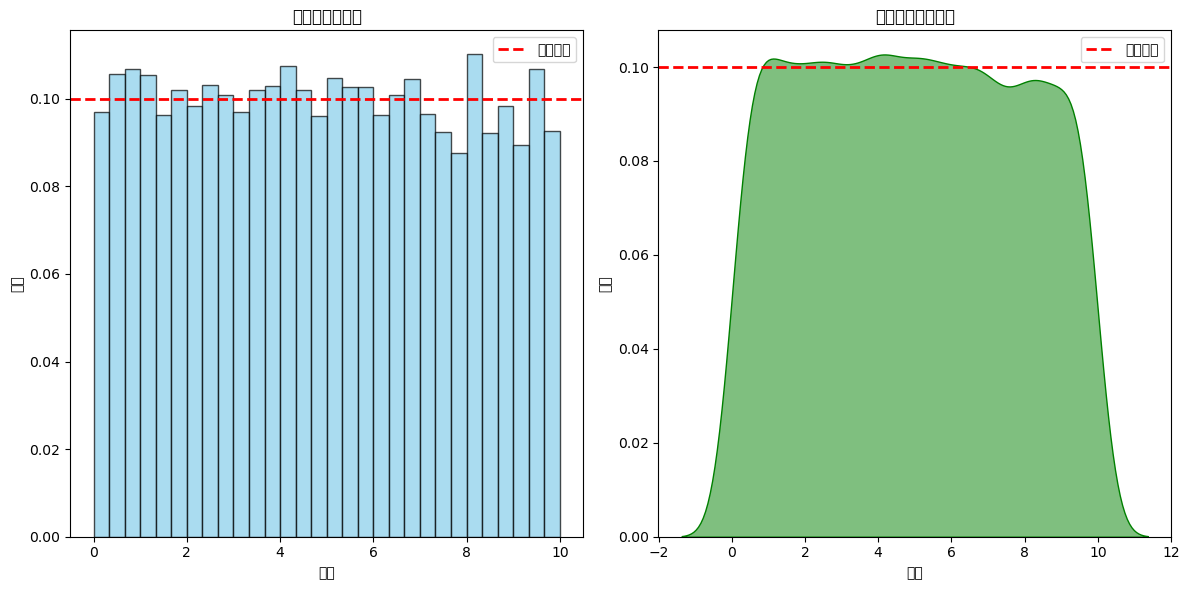

c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21248 (\N{CJK UNIFIED IDEOGRAPH-5300}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31665

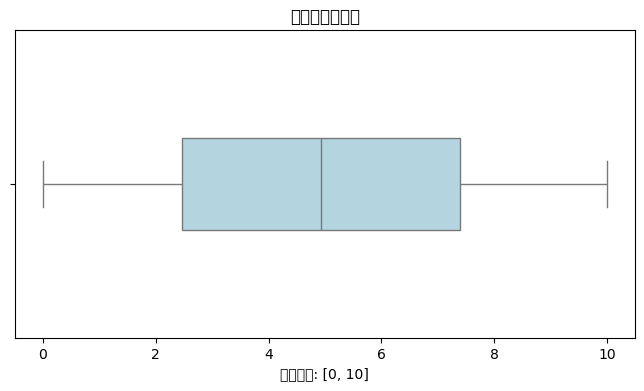


统计信息:
样本数量: 10000
理论范围: [0, 10]
实际最小值: 0.0001
实际最大值: 9.9972
理论均值: 5.0000
实际均值: 4.9416
理论方差: 8.3333
实际方差: 8.2723


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子保证结果可复现
np.random.seed(42)

# 生成均匀分布随机数
n = 10000  # 样本数量
low = 0    # 最小值
high = 10  # 最大值

# 生成均匀分布的随机数列表
uniform_data = np.random.uniform(low, high, n)

# 打印前10个随机数
print("前10个随机数:", uniform_data[:10])

# 绘制分布图
plt.figure(figsize=(12, 6))

# 直方图
plt.subplot(1, 2, 1)
plt.hist(uniform_data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axhline(y=1/(high-low), color='r', linestyle='--', linewidth=2, label='理论密度')
plt.title('均匀分布直方图')
plt.xlabel('数值')
plt.ylabel('密度')
plt.legend()

# 核密度估计图
plt.subplot(1, 2, 2)
sns.kdeplot(uniform_data, color='green', fill=True, alpha=0.5)
plt.axhline(y=1/(high-low), color='r', linestyle='--', linewidth=2, label='理论密度')
plt.title('均匀分布密度估计')
plt.xlabel('数值')
plt.ylabel('密度')
plt.legend()

plt.tight_layout()
plt.show()

# 添加箱线图显示分布范围
plt.figure(figsize=(8, 4))
sns.boxplot(x=uniform_data, color='lightblue', width=0.3)
plt.title('均匀分布箱线图')
plt.xlabel(f'数值范围: [{low}, {high}]')
plt.show()

# 打印统计信息
print(f"\n统计信息:")
print(f"样本数量: {n}")
print(f"理论范围: [{low}, {high}]")
print(f"实际最小值: {np.min(uniform_data):.4f}")
print(f"实际最大值: {np.max(uniform_data):.4f}")
print(f"理论均值: {(low+high)/2:.4f}")
print(f"实际均值: {np.mean(uniform_data):.4f}")
print(f"理论方差: {((high-low)**2)/12:.4f}")
print(f"实际方差: {np.var(uniform_data):.4f}")

In [2]:
n=39
r=n%9
klow=int(n/9)
result = [klow+1 for _ in range(r)] + [klow for _ in range(10-r)]
print(result)

[5, 5, 5, 4, 4, 4, 4, 4, 4, 4]


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from ase import Atoms
from ase.io import read, write
import numpy as np
import tempfile
import os

def smiles_to_ase_atoms(smiles, add_hydrogens=True, optimize_geometry=True, forcefield='MMFF94'):
    """
    将SMILES字符串转换为ASE Atoms对象
    
    参数:
        smiles (str): SMILES字符串
        add_hydrogens (bool): 是否添加氢原子
        optimize_geometry (bool): 是否进行几何优化
        forcefield (str): 使用的力场类型('MMFF94'或'UFF')
        
    返回:
        ase.Atoms: ASE Atoms对象
    """
    # 从SMILES创建RDKit分子对象
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"无法解析SMILES字符串: {smiles}")
    
    # 添加氢原子（如果需要）
    if add_hydrogens:
        mol = Chem.AddHs(mol)
    
    # 生成3D坐标
    AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
    
    # 优化几何结构（如果需要）
    if optimize_geometry:
        if forcefield.upper() == 'MMFF94':
            AllChem.MMFFOptimizeMolecule(mol)
        elif forcefield.upper() == 'UFF':
            AllChem.UFFOptimizeMolecule(mol)
        else:
            raise ValueError(f"不支持的力场类型: {forcefield}")
    
    # 提取原子符号和坐标
    conf = mol.GetConformer()
    symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    positions = np.array([list(conf.GetAtomPosition(i)) for i in range(mol.GetNumAtoms())])
    
    # 创建ASE Atoms对象
    atoms = Atoms(symbols=symbols, positions=positions)
    
    # 可选：添加键信息作为自定义属性
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondTypeAsDouble()))
    atoms.info['bonds'] = bonds
    
    return atoms

def save_ase_atoms_to_xyz(atoms, filename):
    """
    将ASE Atoms对象保存为XYZ文件
    
    参数:
        atoms (ase.Atoms): ASE Atoms对象
        filename (str): 输出文件名
    """
    write(filename, atoms, format='xyz')
    print(f"ASE Atoms对象已保存为: {filename}")

def visualize_ase_atoms(atoms, viewer='ase'):
    """
    可视化ASE Atoms对象
    
    参数:
        atoms (ase.Atoms): ASE Atoms对象
        viewer (str): 可视化工具('ase'或'ngl')
    """
    if viewer == 'ase':
        # 使用ASE的内置可视化功能
        from ase.visualize import view
        view(atoms)
    elif viewer == 'ngl':
        # 使用NGLView进行更高级的可视化
        import nglview as nv
        # 将Atoms对象转换为临时XYZ文件
        with tempfile.NamedTemporaryFile(suffix='.xyz', delete=False) as tmp:
            write(tmp.name, atoms, format='xyz')
            view = nv.show_file(tmp.name)
            os.unlink(tmp.name)
        return view
    else:
        print(f"不支持的可视化工具: {viewer}")

# 示例使用
if __name__ == "__main__":
    # 单个分子转换示例
    ethanol_smiles = "CCO"  # 乙醇
    ethanol_atoms = smiles_to_ase_atoms(ethanol_smiles)
    
    print("乙醇的ASE Atoms对象信息:")
    print(f"原子数量: {len(ethanol_atoms)}")
    print(f"原子符号: {ethanol_atoms.get_chemical_symbols()}")
    print(f"坐标:\n{ethanol_atoms.get_positions()}")
    
    # 保存为XYZ文件
    save_ase_atoms_to_xyz(ethanol_atoms, "ethanol.xyz")
    
    # 批量转换示例
    molecules = {
        "ethanol": "CCO",
        "benzene": "C1=CC=CC=C1",
        "water": "O",
        "carbon_dioxide": "O=C=O",
        "ammonia": "N"
    }
    
    all_atoms = {}
    for name, smiles in molecules.items():
        try:
            atoms = smiles_to_ase_atoms(smiles)
            all_atoms[name] = atoms
            print(f"成功转换 {name}: {smiles}")
        except Exception as e:
            print(f"转换失败 {name} ({smiles}): {e}")
    
    # 使用ASE Atoms对象进行进一步计算
    def calculate_center_of_mass(atoms):
        """计算分子的质心"""
        return atoms.get_center_of_mass()
    
    def calculate_molecular_size(atoms):
        """计算分子尺寸（最大维度）"""
        positions = atoms.get_positions()
        min_coords = np.min(positions, axis=0)
        max_coords = np.max(positions, axis=0)
        return max_coords - min_coords
    
    # 对每个分子计算属性
    for name, atoms in all_atoms.items():
        com = calculate_center_of_mass(atoms)
        size = calculate_molecular_size(atoms)
        print(f"{name}: 质心 = {com}, 尺寸 = {size}")
    
    # 可视化一个分子
    # 取消注释下一行来可视化（需要图形界面）
    # visualize_ase_atoms(ethanol_atoms)
    
    # 使用不同的力场进行优化
    print("\n使用不同力场优化:")
    ethanol_uff = smiles_to_ase_atoms(ethanol_smiles, forcefield='UFF')
    ethanol_mmff = smiles_to_ase_atoms(ethanol_smiles, forcefield='MMFF94')
    
    print(f"UFF优化后的能量: {calculate_molecular_energy(ethanol_uff)}")
    print(f"MMFF94优化后的能量: {calculate_molecular_energy(ethanol_mmff)}")

# 辅助函数：计算分子能量（示例）
def calculate_molecular_energy(atoms):
    """
    计算分子能量（简化示例）
    
    注意：这是一个简化示例，实际计算需要使用量子化学或分子力学方法
    """
    # 这里只是一个示例，实际应用中需要使用适当的计算器
    # 例如：atoms.calc = SomeCalculator()
    # 然后返回 atoms.get_potential_energy()
    
    # 简化版本：返回原子数的平方作为"能量"
    return len(atoms) ** 2


In [21]:
import json
data = {
    "[H]C([H])([H])O": [
        [
            1
        ],
        [],
        [],
        [],
        []
    ]
}
with open('j.json','w') as j:
    json.dump(data,j,indent=2,separators=(',',':'))

In [23]:
import numpy as np
i = np.ones((4,1,3))
l = 2*np.ones((1,3,3))
print(i.shape)
print(l.shape)
print(np.dot(i,l).shape)

(4, 1, 3)
(1, 3, 3)
(4, 1, 1, 3)


In [27]:
import numpy as np

# 创建原始矩阵 (4, 1, 3)
original_matrix = np.random.rand(4, 1, 3)
print("原始矩阵形状:", original_matrix.shape)
print("原始矩阵:")
print(original_matrix)

# 使用 np.repeat 扩展第二个维度
expanded_matrix = np.repeat(original_matrix, 3, axis=1)

print("\n扩展后矩阵形状:", expanded_matrix.shape)
print("扩展后矩阵:")
print(expanded_matrix)
print(expanded_matrix[0][0][0])

原始矩阵形状: (4, 1, 3)
原始矩阵:
[[[0.44296056 0.94326872 0.73334051]]

 [[0.21841954 0.59328852 0.81194028]]

 [[0.49053966 0.89646805 0.03038328]]

 [[0.27331573 0.00370753 0.2636837 ]]]

扩展后矩阵形状: (4, 3, 3)
扩展后矩阵:
[[[0.44296056 0.94326872 0.73334051]
  [0.44296056 0.94326872 0.73334051]
  [0.44296056 0.94326872 0.73334051]]

 [[0.21841954 0.59328852 0.81194028]
  [0.21841954 0.59328852 0.81194028]
  [0.21841954 0.59328852 0.81194028]]

 [[0.49053966 0.89646805 0.03038328]
  [0.49053966 0.89646805 0.03038328]
  [0.49053966 0.89646805 0.03038328]]

 [[0.27331573 0.00370753 0.2636837 ]
  [0.27331573 0.00370753 0.2636837 ]
  [0.27331573 0.00370753 0.2636837 ]]]
0.4429605617024349


In [25]:
import numpy as np

# 创建一个示例矩阵
matrix = np.random.rand(3, 4, 2)
print("原始矩阵形状:", matrix.shape)

# 设置输出选项以显示所有元素
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

print("展开形式的矩阵:")
print(matrix)

# 恢复默认设置（可选）
np.set_printoptions(threshold=1000, linewidth=75)  # 恢复默认值

原始矩阵形状: (3, 4, 2)
展开形式的矩阵:
[[[0.10905029 0.95116323]
  [0.96264722 0.65460876]
  [0.21907102 0.86675085]
  [0.98358287 0.13330139]]

 [[0.7256388  0.72003716]
  [0.86071334 0.75088924]
  [0.75491631 0.93872554]
  [0.3975959  0.17409593]]

 [[0.16459513 0.66617443]
  [0.24840544 0.93714953]
  [0.20559296 0.92932318]
  [0.75079031 0.61056726]]]


In [1]:
from ase.io import read
from ase.visualize import view  # 可选，用于可视化结构

# 读取单个结构文件
# 替换 'your_file.ext' 为你的实际文件路径和名称
atoms = read('test/opt/system/species/[H]C([H])([H])[H]/2/nequipOpt.traj') 

# 查看结构（可选）
view(atoms)

# 尝试获取能量
# 注意：能量信息是否可用取决于文件格式和内容
try:
    energy = atoms.get_potential_energy()
    print(f"结构的能量为: {energy} eV")
except PropertyNotImplementedError:
    print("该文件或 Atoms 对象中没有存储能量信息。")
    # 可能需要通过其他方式获取能量，例如从计算器的结果中读取

结构的能量为: -601.2363891601562 eV


In [2]:
from ase.io import read

# 方法一：直接使用索引 -1 读取最后一个结构（最推荐，高效）
# 这是因为 ASE 可以智能地定位到文件末尾，而不需要加载整个文件到内存
try:
    last_atoms = read('test/opt/system/species/[H]C([H])([H])[H]/2/nequipOpt.traj', index=-1) # index=-1 表示最后一个
    final_energy = last_atoms.get_potential_energy()
    print(f"最后一个结构的能量为: {final_energy} eV")

except FileNotFoundError:
    print("错误：找不到指定的 .traj 文件，请检查路径。")
except Exception as e:
    print(f"读取文件时发生错误: {e}")

最后一个结构的能量为: -601.2363891601562 eV


In [4]:
import json
with open ('record_adscheck.json','r') as j:
    d = json.load(j)
    print(len(d))

24


In [5]:
from ase.io import read
import numpy as np

def analyze_poscar_pbc(poscar_file):
    """
    读取 POSCAR 文件并分析其周期性边界条件
    
    参数:
    poscar_file: POSCAR 文件路径
    
    返回:
    包含 PBC 信息的字典
    """
    # 读取 POSCAR 文件
    atoms = read(poscar_file)
    
    # 获取晶胞向量
    cell = atoms.get_cell()
    
    # 计算晶胞大小（每个方向的长度）
    a = np.linalg.norm(cell[0])  # a 方向长度
    b = np.linalg.norm(cell[1])  # b 方向长度
    c = np.linalg.norm(cell[2])  # c 方向长度
    
    # 计算晶胞角度
    alpha = np.degrees(np.arccos(np.dot(cell[1], cell[2]) / (b * c)))
    beta = np.degrees(np.arccos(np.dot(cell[0], cell[2]) / (a * c)))
    gamma = np.degrees(np.arccos(np.dot(cell[0], cell[1]) / (a * b)))
    
    # 获取 PBC 设置（哪些方向是周期性的）
    pbc_flags = atoms.get_pbc()
    
    # 获取晶胞体积
    volume = atoms.get_volume()
    
    # 返回所有信息
    return {
        'cell_vectors': cell,
        'cell_lengths': (a, b, c),
        'cell_angles': (alpha, beta, gamma),
        'pbc_flags': pbc_flags,
        'volume': volume,
        'pbc_directions': get_pbc_directions(pbc_flags)
    }

def get_pbc_directions(pbc_flags):
    """
    将 PBC 标志转换为方向描述
    
    参数:
    pbc_flags: 三个布尔值的元组或列表，表示 x, y, z 方向的周期性
    
    返回:
    方向描述字符串
    """
    directions = []
    if pbc_flags[0]:
        directions.append('x')
    if pbc_flags[1]:
        directions.append('y')
    if pbc_flags[2]:
        directions.append('z')
    
    if not any(pbc_flags):
        return "无周期性边界条件"
    elif all(pbc_flags):
        return "三维周期性 (x, y, z)"
    else:
        return f"{len(directions)}维周期性 ({', '.join(directions)})"

# 使用示例
if __name__ == "__main__":
    poscar_file = 'test/opt/slab/opt.vasp'  # 替换为您的 POSCAR 文件路径
    
    try:
        pbc_info = analyze_poscar_pbc(poscar_file)
        
        print("POSCAR 文件分析结果:")
        print("=" * 50)
        print(f"晶胞向量:\n{pbc_info['cell_vectors']}")
        print(f"晶胞长度 (a, b, c): {pbc_info['cell_lengths']} Å")
        print(f"晶胞角度 (α, β, γ): {pbc_info['cell_angles']} °")
        print(f"周期性边界条件: {pbc_info['pbc_directions']}")
        print(f"PBC 标志 (x, y, z): {pbc_info['pbc_flags']}")
        print(f"晶胞体积: {pbc_info['volume']} Å³")
        
    except FileNotFoundError:
        print(f"错误: 找不到文件 {poscar_file}")
    except Exception as e:
        print(f"错误: {e}")

POSCAR 文件分析结果:
晶胞向量:
Cell([[10.8, 0.0, 0.0], [5.4, 9.353074360871938, 0.0], [0.0, 0.0, 26.4152]])
晶胞长度 (a, b, c): (10.8, 10.8, 26.4152) Å
晶胞角度 (α, β, γ): (90.0, 90.0, 60.00000000000001) °
周期性边界条件: 三维周期性 (x, y, z)
PBC 标志 (x, y, z): [ True  True  True]
晶胞体积: 2668.2839624588887 Å³


识别到的位点:


c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38754 (\N{CJK UNIFIED IDEOGRAPH-9762}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\renyq\anaconda3\envs\ASE_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35782

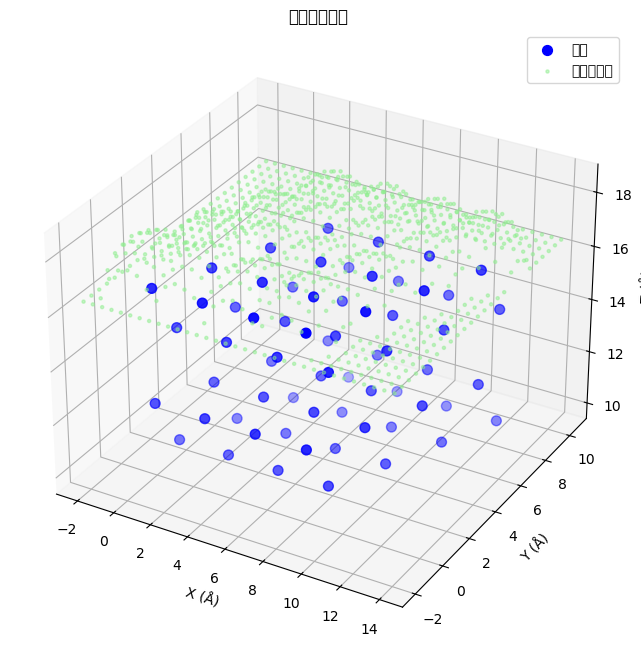

In [1]:
import numpy as np
from ase import Atoms
from ase.io import read
from scipy.spatial import KDTree, cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Tuple, Dict, Set
from collections import defaultdict

class SurfaceSiteFinder:
    def __init__(self, atoms: Atoms, surface_direction: int = 2):
        """
        初始化表面位点查找器
        
        参数:
        atoms: ASE Atoms 对象，表示平板结构
        surface_direction: 表面法线方向 (0=x, 1=y, 2=z)
        """
        self.atoms = atoms
        self.surface_direction = surface_direction
        self.grid_points = None
        self.wrapped_points = None
        self.site_atoms = defaultdict(list)
        self.site_positions = {}
        self.site_vectors = {}
        
    def create_grid(self, grid_spacing: float = 0.1, height_above_surface: float = 5.0):
        """
        在表面上创建密集网格
        
        参数:
        grid_spacing: 网格点间距 (Å)
        height_above_surface: 网格在表面上方的初始高度 (Å)
        """
        # 获取表面原子的坐标
        positions = self.atoms.get_positions()
        
        # 确定表面方向
        if self.surface_direction == 0:  # x方向为表面法线
            surface_coords = positions[:, 1:]
            max_height = np.max(positions[:, 0])
        elif self.surface_direction == 1:  # y方向为表面法线
            surface_coords = positions[:, [0, 2]]
            max_height = np.max(positions[:, 1])
        else:  # z方向为表面法线 (默认)
            surface_coords = positions[:, :2]
            max_height = np.max(positions[:, 2])
        
        # 确定网格的边界
        x_min, y_min = np.min(surface_coords, axis=0)
        x_max, y_max = np.max(surface_coords, axis=0)
        
        # 扩展边界以确保覆盖整个表面
        x_min, x_max = x_min - 2.0, x_max + 2.0
        y_min, y_max = y_min - 2.0, y_max + 2.0
        
        # 创建网格点
        x_grid = np.arange(x_min, x_max, grid_spacing)
        y_grid = np.arange(y_min, y_max, grid_spacing)
        xx, yy = np.meshgrid(x_grid, y_grid)
        
        # 设置网格高度
        if self.surface_direction == 0:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([zz.ravel(), xx.ravel(), yy.ravel()]).T
        elif self.surface_direction == 1:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([xx.ravel(), zz.ravel(), yy.ravel()]).T
        else:
            zz = np.full_like(xx, max_height + height_above_surface)
            self.grid_points = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
            
        return self.grid_points
    
    def wrap_grid_to_surface(self,height_above_surface,contact_distance: float = 2.0, step_size: float = 0.1):
        """
        将网格点向表面平移，直到接近原子
        
        参数:
        contact_distance: 接触距离阈值 (Å)
        step_size: 平移步长 (Å)
        """
        if self.grid_points is None:
            raise ValueError("请先创建网格点")
            
        # 创建原子位置的KD树用于快速最近邻搜索
        atom_positions = self.atoms.get_positions()
        tree = cKDTree(atom_positions)
        
        # 初始化包裹后的点
        wrapped_points = self.grid_points.copy()
        
        # 确定平移方向
        if self.surface_direction == 0:
            direction = np.array([-1, 0, 0])
        elif self.surface_direction == 1:
            direction = np.array([0, -1, 0])
        else:
            direction = np.array([0, 0, -1])
            
        # 逐步平移网格点
        max_steps = int(height_above_surface / step_size) + 10
        for step in range(max_steps):
            # 计算每个点到最近原子的距离
            distances, indices = tree.query(wrapped_points)
            
            # 找到尚未接触原子的点
            not_contacted = distances > contact_distance
            
            if not np.any(not_contacted):
                break
                
            # 将这些点向表面方向移动
            wrapped_points[not_contacted] += direction * step_size
        
        self.wrapped_points = wrapped_points
        return wrapped_points
    
    def find_sites(self, contact_distance: float = 2.0, multi_site_threshold: float = 1.0):
        """
        识别表面位点
        
        参数:
        contact_distance: 接触距离阈值 (Å)
        multi_site_threshold: 多重位点识别阈值 (Å)
        """
        if self.wrapped_points is None:
            raise ValueError("请先执行网格包裹")
            
        # 创建原子位置的KD树
        atom_positions = self.atoms.get_positions()
        tree = cKDTree(atom_positions)
        
        # 对于每个包裹后的网格点，找到接触的原子
        for i, point in enumerate(self.wrapped_points):
            # 找到距离此点在一定范围内的所有原子
            indices = tree.query_ball_point(point, contact_distance)
            
            if indices:
                # 将原子索引转换为可哈希的元组
                atom_tuple = tuple(sorted(indices))
                self.site_atoms[atom_tuple].append(point)
        
        # 识别位点类型并计算位点位置
        for atom_indices, points in self.site_atoms.items():
            if len(atom_indices) == 1:
                # 顶位 - 使用原子位置
                atom_idx = atom_indices[0]
                self.site_positions[atom_indices] = atom_positions[atom_idx]
                self.site_vectors[atom_indices] = np.mean(points, axis=0)
            else:
                # 桥位或多重位点 - 使用原子位置的平均值
                site_atoms = atom_positions[list(atom_indices)]
                self.site_positions[atom_indices] = np.mean(site_atoms, axis=0)
                self.site_vectors[atom_indices] = np.mean(points, axis=0)
        
        return self.site_atoms, self.site_positions, self.site_vectors
    
    def classify_sites(self, multi_site_threshold: float = 1.0):
        """
        分类位点类型
        
        参数:
        multi_site_threshold: 多重位点识别阈值 (Å)
        """
        site_types = {}
        
        for atom_indices in self.site_atoms.keys():
            if len(atom_indices) == 1:
                site_types[atom_indices] = "顶位"
            elif len(atom_indices) == 2:
                site_types[atom_indices] = "桥位"
            else:
                # 检查是否构成多重位点
                atom_positions = self.atoms.get_positions()[list(atom_indices)]
                centroid = np.mean(atom_positions, axis=0)
                
                # 计算原子到质心的最大距离
                max_distance = np.max(np.linalg.norm(atom_positions - centroid, axis=1))
                
                if max_distance < multi_site_threshold:
                    site_types[atom_indices] = f"{len(atom_indices)}重位点"
                else:
                    site_types[atom_indices] = "复杂位点"
        
        return site_types
    
    def visualize(self, show_grid: bool = False, show_wrapped: bool = True):
        """
        可视化结果
        
        参数:
        show_grid: 是否显示初始网格
        show_wrapped: 是否显示包裹后的网格
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # 绘制原子
        positions = self.atoms.get_positions()
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], 
                  c='blue', s=50, label='原子')
        
        # 绘制初始网格点（如果要求）
        if show_grid and self.grid_points is not None:
            ax.scatter(self.grid_points[:, 0], self.grid_points[:, 1], self.grid_points[:, 2],
                      c='gray', s=5, alpha=0.3, label='初始网格')
        
        # 绘制包裹后的网格点（如果要求）
        if show_wrapped and self.wrapped_points is not None:
            ax.scatter(self.wrapped_points[:, 0], self.wrapped_points[:, 1], self.wrapped_points[:, 2],
                      c='lightgreen', s=5, alpha=0.5, label='包裹后网格')
        
        # 绘制位点位置
        colors = ['red', 'orange', 'purple', 'cyan', 'magenta', 'yellow']
        color_idx = 0
        
        for atom_indices, position in self.site_positions.items():
            site_type = self.classify_sites().get(atom_indices, "未知")
            
            if site_type == "顶位":
                color = 'red'
                marker = 'o'
                size = 100
            elif site_type == "桥位":
                color = 'orange'
                marker = 's'
                size = 120
            elif "重位点" in site_type:
                color = colors[color_idx % len(colors)]
                color_idx += 1
                marker = 'D'
                size = 150
            else:
                color = 'gray'
                marker = 'x'
                size = 80
            
            ax.scatter(position[0], position[1], position[2], 
                      c=color, marker=marker, s=size, label=site_type)
            
            # 绘制向量（从位点到网格点平均位置）
            if atom_indices in self.site_vectors:
                vector = self.site_vectors[atom_indices]
                ax.quiver(position[0], position[1], position[2],
                         vector[0]-position[0], vector[1]-position[1], vector[2]-position[2],
                         color=color, arrow_length_ratio=0.1)
        
        # 设置图表属性
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.set_title('表面位点识别')
        
        # 避免重复的图例标签
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())
        
        plt.show()

# 使用示例
if __name__ == "__main__":
    # 示例1: 创建一个简单的平板结构
    # 这里我们创建一个FCC(100)表面的简单示例
    from ase.build import hcp0001, add_adsorbate
    
    # 创建铜的(100)表面
    slab = hcp0001('Ru', size=(4, 4, 4), vacuum=10.0)
    
    # 初始化查找器
    finder = SurfaceSiteFinder(slab)
    
    # 创建网格
    grid_points = finder.create_grid(grid_spacing=0.5, height_above_surface=3.0)
    
    # 包裹网格到表面
    wrapped_points = finder.wrap_grid_to_surface(height_above_surface=2, step_size=0.1)
    
    # 查找位点
    sites, positions, vectors = finder.find_sites(contact_distance=1.5)
    
    # 分类位点
    site_types = finder.classify_sites(multi_site_threshold=1.2)
    
    # 打印结果
    print("识别到的位点:")
    for atom_indices, site_type in site_types.items():
        print(f"{site_type}: 原子 {atom_indices}, 位置 {positions[atom_indices]}")
    
    # 可视化
    finder.visualize(show_grid=False, show_wrapped=True)
    
    # 示例2: 从文件读取结构
    # 假设有一个POSCAR文件
    # atoms = read('POSCAR')
    # finder = SurfaceSiteFinder(atoms)
    # ... 其余步骤相同